# Лабораторная работа №1 

ДВ Метод конечных элементов, ММФ, БГУ

преподаватель Лаврова О.А., сентябрь 2021

## Задача Дирихле для уравнения Пуассона

### Постановка задачи

Для заданного точного решения $u(x,y)$ построить задачу Дирихле для уравнения Пуассона в единичном квадрате $[0,1] \times [0,1]$

\begin{equation*}
\left\{
\begin{array}{ll}
-\Delta u=f, & \quad (x,y) \in \Omega=(0,1)^2\\
u=g, & \quad (x,y) \in \partial \Omega.
\end{array}
\right.
\end{equation*}

Решить построенную задачу средствами библиотеки FEniCS и сравнить визуально численное решение, полученное методом конечных элементов, с точным решением $u(x,y)$. 

Например, полагаем $u(x,y) = x^3+y^3$. Тогда задача Дирихле примет вид

\begin{equation*}
\left\{
\begin{array}{ll}
-\Delta u=-6 x - 6 y, & \quad (x,y) \in \Omega=(0,1)^2\\
u(x,y)=y^3, & \quad (x,y) \in \partial \Omega \cap \{(x,y) : x=0\} \\
u(x,y)=1+y^3, & \quad (x,y) \in \partial \Omega \cap \{(x,y) : x=1\}\\
u(x,y)=x^3, & \quad (x,y) \in \partial \Omega \cap \{(x,y) : y=0\}\\
u(x,y)=x^3+1. & \quad (x,y) \in \partial \Omega \cap \{(x,y) : y=1\}\\
\end{array}
\right.
\end{equation*}

### Реализация

Будет осуществлена поэтапно:
1. Построение сетки
2. Определение конечно-элементного пространства
3. Определение граничных условий
4. Определение вариационной задачи
5. Решение системы линейных алгебраических уравнений
6. Постпроцессинг (визуализация, вычисление ошибки)

#### Подключаем библиотеки

In [1]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2021-09-15 13:42:35--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1946 (1.9K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   1.90K  --.-KB/s    in 0s      

2021-09-15 13:42:35 (29.3 MB/s) - ‘/tmp/fenics-install.sh’ saved [1946/1946]

+ PYBIND11_INSTALL_SCRIPT_PATH=https://fem-on-colab.github.io/releases/pybind11-install.sh
+ [[ https://fem-on-colab.github.io/releases/pybind11-install.sh == http* ]]
+ wget https://fem-on-colab.github.io/releases/pybind11-install.sh -O /tmp/pybind11-install.sh
--2021-09-15 13:42:35--  https://fem-on-colab.github.io/releases/pybind11-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.1

In [2]:
from fenics import *
import fenics

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
import numpy as np

#### 1 Этап. Построение сетки

In [6]:
mesh = UnitSquareMesh(20, 8)

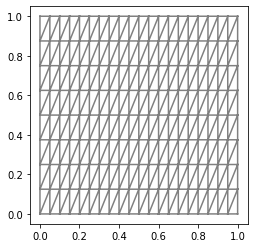

In [7]:
plot(mesh)

#### 2 Этап. Определение конечно-элементного пространства

In [8]:
V1 = FunctionSpace(mesh, 'P', 1) # линейные элементы на треугольниках

Calling FFC just-in-time (JIT) compiler, this may take some time.


In [9]:
V2 = FunctionSpace(mesh, 'P', 2) # квадратичные элементы на треугольниках

Calling FFC just-in-time (JIT) compiler, this may take some time.


In [10]:
V3 = FunctionSpace(mesh, 'P', 3) # кубические элементы на треугольниках

Calling FFC just-in-time (JIT) compiler, this may take some time.


**Важно**: In FEniCS we DO NOT specify the boundary conditions as part of the function space, so it is sufficient to work with one common space $V$ for both the trial and test functions in the program [From FEniCS Tutorial 2016]

In [12]:
u1 = TrialFunction(V1)
v1 = TestFunction(V1)

In [13]:
u2 = TrialFunction(V2)
v2 = TestFunction(V2)

In [14]:
u3 = TrialFunction(V3)
v3 = TestFunction(V3)

##### 2.1. Определение точного решения исходной задачи

Точное решение будет использовано на этапе постпроцессинга

In [36]:
u_exact = Expression('pow(x[0],3) + pow(x[1],3)', degree=3)

Для визуализации необходимо описание функции (тип Expression) преобразовать в функцию

In [37]:
u_exact_plt = interpolate(u_exact,V3) 

**Важно**: if an Expression is used to represent an exact solution which is used to evaluate the accuracy of a computed solution, **a higher degree** than for the space $V$ must be used for the expression (one or two degree higher) [From FEniCS Tutorial 2016]

#### 3 Этап. Определение граничных условий

#####  3.1. Описание границы

In [16]:
tol = 1E-14
def boundary(x):
    return abs(x[0]) < tol or abs(x[1]) < tol or abs(x[0] - 1) < tol or abs(x[1] - 1) < tol

##### 3.2. Задание функции из условия Дирихле

In [17]:
g_D1 = Expression('pow(x[0],3) + pow(x[1],3)', degree=1)

In [23]:
g_D2 = Expression('pow(x[0],3) + pow(x[1],3)', degree=2)

In [24]:
g_D3 = Expression('pow(x[0],3) + pow(x[1],3)', degree=3)

**Важно**: To obtain optimal (order of) accuracy in computations, it is usually a good choice to use **the same degree** as for the space $V$ that is used for the trial and test functions [From FEniCS Tutorial 2016]

##### 3.3. Граничное условие 

In [20]:
bc1 = DirichletBC(V1, g_D1, boundary)

In [25]:
bc2 = DirichletBC(V2, g_D2, boundary)

In [26]:
bc3 = DirichletBC(V3, g_D3, boundary)

#### 4 Этап. Определение вариационной задачи

##### Определение функции правой части

In [27]:
f = Expression('-6*x[0]-6*x[1]', degree=1)

In [28]:
a1 = dot(grad(u1), grad(v1))*dx # линейные элементы
L1 = f*v1*dx

In [29]:
a2 = dot(grad(u2), grad(v2))*dx # квадратичные элементы
L2 = f*v2*dx

In [30]:
a3 = dot(grad(u3), grad(v3))*dx # кубические элементы
L3 = f*v3*dx

**Важно**: The language used to express weak forms is called UFL (Unified Form Language) and is an integral part of FEniCS [From FEniCS Tutorial 2016]

#### 5 Этап. Решение системы линейных алгебраических уравнений

In [31]:
u1 = Function(V1) # переопределение функции u1
solve(a1 == L1, u1, bc1)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [32]:
u2 = Function(V2) # переопределение функции u2
solve(a2 == L2, u2, bc2)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [33]:
u3 = Function(V3) # переопределение функции u3
solve(a3 == L3, u3, bc3)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


#### 6 Этап. Постпроцессинг

##### 6.1. Визуализация 

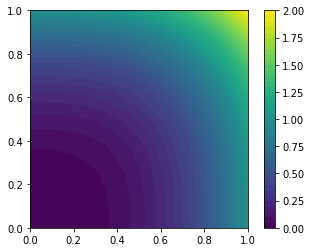

In [34]:
p1 = plot(u1);
plt.colorbar(p1);

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


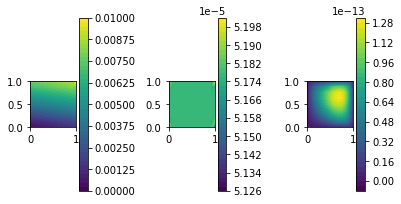

In [38]:
plt.subplot(1,5,1)
p2 = plot(abs(u1-u_exact_plt));
plt.colorbar(p2);

plt.subplot(1,5,3)
p3 = plot(abs(u2-u_exact_plt));
plt.colorbar(p3);

plt.subplot(1,5,5)
p4 = plot(abs(u3-u_exact_plt));
plt.colorbar(p4);

##### 6.2. Вычисление ошибки 

###### 1) Вычисление ошибки в норме $L_2$

In [39]:
error_L2_1 = errornorm(u_exact,u1,'L2')
error_L2_2 = errornorm(u_exact,u2,'L2')

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [40]:
print(error_L2_1,error_L2_2)

0.005461746684974001 6.752708685465721e-05


Замечание: Обратите внимание на уменьшение ошибки за счет перехода из пространства $P1$-элементов в пространство $P2$-элементов на одинаковой сетке.  

##### 2) Вычисление ошибки в максимальной норме 

Данный код реализует вычисление ошибки в узлах сетки (не в степенях свободы конечно-элементого решения)

In [ ]:
vertex_values_u_exact = u_exact.compute_vertex_values(mesh)
vertex_values_u1 = u1.compute_vertex_values(mesh)
vertex_values_u2 = u2.compute_vertex_values(mesh)
error_max_1 = np.max(np.abs(vertex_values_u_exact - vertex_values_u1))
error_max_2 = np.max(np.abs(vertex_values_u_exact - vertex_values_u2))

In [ ]:
print(error_max_1,error_max_2)

2.220446049250313e-15 5.340172748447003e-14


**Важно**: We have here used the maximum and absolute value functions from **numpy**, because these are much more efficient for large arrays (a factor of 30) than Python's built-in **max** and **abs** functions [From FEniCS Tutorial 2016]